In [1]:
%matplotlib ipympl
#%matplotlib widget
#%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyobs
# from scipy.stats import norm
import bison

# plt.rcParams.update({
#     "text.usetex"      : True,
#     "font.family"      : "Helvetica",
#     "mathtext.fontset" : "dejavuserif"
# })
plt.rcParams.update({
    "axes.axisbelow"   : True,
})

In [2]:
### Data file ###
data = bison.load("Cnfgs_measurement/WF-slices_beta617_seed123456.dat")
# print(data.keys())
# print(data['Configuration 40'].keys())
# print(data['Configuration 40']['Q'].shape)
# print(data['MC History tag-1']['dH'].shape)
# print(data['MC History tag-1']['Acc/Rej'].shape)

[Bison] : Reading file Cnfgs_measurement/WF-slices_beta617_seed123456.dat
[Bison] : File created by gmorandi at ampere on Tue Dec 19 00:02:04 2023
[Bison] : Read 147.311 MB at 446.197 MB/s


In [3]:
##############################
### General run parameters ###
##############################
beta      =  data['beta coupling']
L1, L2, L3, T = data['Lattice']
V         =  L1 * L2 * L3 * T
D         =  4
Ns        =  data['Number of steps of OMF4 integrator']
tauMD     =  data['Length of each MD trajectory']
Ntraj     =  data['MD trajectories']
MC_step   =  data['MC measure step']
eps_WF    =  data['epsilon WF']
WF_evol   =  data['WF evolutions from t = 0']
WF_step   =  data['WF measure step']
Nwf       =  WF_evol // WF_step + 1
Nc_run    = Ntraj // MC_step

Ncnfg0 = 0
Nh     = 0
for key in data:
    if key.startswith('Configuration'):
        Ncnfg0 += 1
    if key.startswith('MC History'):
        Nh += 1


print(f"\n Lattice                =  [{L1}x{L2}x{L3}x{T}]")
print(f" Lattice volume         =  {V}")
print(f" beta                   =  {beta}")
print(f" Steps of OMF4          =  {Ns}")
print(f" tau MD                 =  {tauMD}")
print(f" MD trajectories        =  {Ntraj}")
print(f" MC interval between measurements  =  {MC_step}")
print(f" epsilon of Wilson Flow =  {eps_WF}")
print(f" Wilson Flow evolutions =  {WF_evol}")
print(f" Wilson Flow steps between measurements =  {WF_step}\n")

print(f" Measured flow times:")
print(*(f" t = {eps_WF * WF_step * i:.2f}" for i in range(Nwf)), sep='\n')

Ntherm0 = 200
print(f"\n Total number of measurements = {Ncnfg0}, extracted from {Nh} runs, {Nc_run} meas. each.")
print(f" Total number of configurations = {int(Ncnfg0 * tauMD * MC_step)} MDU")
print(f" Preliminary thermalization trajectories = {Ntherm0}, i.e. {int(Ntherm0 * tauMD)} MDU")
print(f" we should reach 5 x max(tau_int) [MDU], namely ~ {int(5 * MC_step * tauMD * 20)} MDU")
print(f" so we skip {(5 * 20 * MC_step - Ntherm0)*int(tauMD)} MDUs in the current initial data.\n")
print(f" In other words we have to skip {(5 * 20 * MC_step - Ntherm0) // MC_step} measurements.")

skip = (5 * 20 * MC_step - Ntherm0) // MC_step

Ncnfg = Ncnfg0 - skip
print(f" Total configs. = {Ncnfg} (after removing initial due to therm.)")


 Lattice                =  [32x32x32x64]
 Lattice volume         =  2097152
 beta                   =  6.17
 Steps of OMF4          =  8
 tau MD                 =  2.0
 MD trajectories        =  200
 MC interval between measurements  =  10
 epsilon of Wilson Flow =  0.02
 Wilson Flow evolutions =  300
 Wilson Flow steps between measurements =  5

 Measured flow times:
 t = 0.00
 t = 0.10
 t = 0.20
 t = 0.30
 t = 0.40
 t = 0.50
 t = 0.60
 t = 0.70
 t = 0.80
 t = 0.90
 t = 1.00
 t = 1.10
 t = 1.20
 t = 1.30
 t = 1.40
 t = 1.50
 t = 1.60
 t = 1.70
 t = 1.80
 t = 1.90
 t = 2.00
 t = 2.10
 t = 2.20
 t = 2.30
 t = 2.40
 t = 2.50
 t = 2.60
 t = 2.70
 t = 2.80
 t = 2.90
 t = 3.00
 t = 3.10
 t = 3.20
 t = 3.30
 t = 3.40
 t = 3.50
 t = 3.60
 t = 3.70
 t = 3.80
 t = 3.90
 t = 4.00
 t = 4.10
 t = 4.20
 t = 4.30
 t = 4.40
 t = 4.50
 t = 4.60
 t = 4.70
 t = 4.80
 t = 4.90
 t = 5.00
 t = 5.10
 t = 5.20
 t = 5.30
 t = 5.40
 t = 5.50
 t = 5.60
 t = 5.70
 t = 5.80
 t = 5.90
 t = 6.00

 Total number of 

In [4]:
########################################################
### Loading history run and observables measurements ###
########################################################
WF_EClov = np.zeros((Ncnfg0, Nwf, T))
WF_Plaq  = np.zeros((Ncnfg0, Nwf, T))
WF_Q     = np.zeros((Ncnfg0, Nwf, T))
Acc      = np.zeros((Nh * Ntraj)) 
dH       = np.zeros((Nh * Ntraj))

for i in range(Ncnfg0):
    WF_EClov[i,:,:] = data[f'Configuration {i+1}']['E_Clov']
    WF_Plaq[i,:,:]  = data[f'Configuration {i+1}']['Plaquette']
    WF_Q[i,:,:]     = data[f'Configuration {i+1}']['Q'] 

for i in range(Nh):
    Acc[i*Ntraj:(i+1)*Ntraj] = data[f'MC History tag-{i}']['Acc/Rej']
    dH[i*Ntraj:(i+1)*Ntraj]  = data[f'MC History tag-{i}']['dH']

print(f"\n Acceptance rate        =  {np.mean(Acc)*100:.0f} %")
print(f" < |dH| >               =  {np.mean(np.abs(dH)):.3e}\n")


 Acceptance rate        =  95 %
 < |dH| >               =  1.087e-01



In [5]:
### Compute <E_Clov>_t and tau_int ###
t_WF = np.array([eps_WF * WF_step * i for i in range(Nwf)])
obsEClov = pyobs.observable(description=f'Energy Density at several WF times')
obsEClov.create('Ensemble A', np.sum(WF_EClov[skip:,:,:], axis=2).flatten(), shape=(Nwf,)) 
obsEClov /= V

print(*(f"(t = {t_WF[i]:.2f}) :    <E_Clov> = {obsEClov[i]}                 tau_int = {obsEClov[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsEClov[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    <E_Clov> = 1.955309(15)
                 tau_int = 0.626 +- 0.071

(t = 0.10) :    <E_Clov> = 1.373092(21)
                 tau_int = 0.666 +- 0.075

(t = 0.20) :    <E_Clov> = 0.859936(25)
                 tau_int = 0.823 +- 0.102

(t = 0.30) :    <E_Clov> = 0.548216(25)
                 tau_int = 1.017 +- 0.136

(t = 0.40) :    <E_Clov> = 0.371003(25)
                 tau_int = 1.224 +- 0.175

(t = 0.50) :    <E_Clov> = 0.266806(24)
                 tau_int = 1.431 +- 0.217

(t = 0.60) :    <E_Clov> = 0.201888(24)
                 tau_int = 1.636 +- 0.262

(t = 0.70) :    <E_Clov> = 0.159063(23)
                 tau_int = 1.836 +- 0.308

(t = 0.80) :    <E_Clov> = 0.129371(23)
                 tau_int = 2.027 +- 0.356

(t = 0.90) :    <E_Clov> = 0.107914(23)
                 tau_int = 2.215 +- 0.404

(t = 1.00) :    <E_Clov> = 0.091868(23)
                 tau_int = 2.395 +- 0.454

(t = 1.10) :    <E_Clov> = 0.079524(23)
                 tau_int = 2.535 +- 0.480

(t =

In [6]:
### Compute <Plaq>_t, <E_Plaq>_t and tau_int ###
obsPlaq = pyobs.observable(description=f'Plaquette at several WF times')
obsPlaq.create('Ensemble A', np.sum(WF_Plaq[skip:,:,:], axis=2).flatten(), shape=(Nwf,))
obsPlaq /= V
obsEPlaq = beta * (1.0 - obsPlaq) * D * (D-1) / 2

# ### same result using: ###
# # WF_EPlaq = np.zeros((Ncnfg0, Nwf, T))
# # WF_EPlaq = ((beta * D * (D-1) / 2)) * (V/T - WF_Plaq)
# # obsEPlaq2 = pyobs.observable(description=f'E_Plaq v2 at several WF times')
# # obsEPlaq2.create('Ensemble A', np.sum(WF_EPlaq[skip:,:,:], axis=2).flatten(), shape=(Nwf,))
# # obsEPlaq2 /= V

print(*(f"(t = {t_WF[i]:.2f}) :     <E_Plaq> = {obsEPlaq[i]}                  tau_int = {obsEPlaq[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsEPlaq[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :     <E_Plaq> = 14.405781(86)
                  tau_int = 0.539 +- 0.055

(t = 0.10) :     <E_Plaq> = 6.054021(74)
                  tau_int = 0.566 +- 0.057

(t = 0.20) :     <E_Plaq> = 2.619946(54)
                  tau_int = 0.611 +- 0.069

(t = 0.30) :     <E_Plaq> = 1.279839(42)
                  tau_int = 0.750 +- 0.085

(t = 0.40) :     <E_Plaq> = 0.713735(37)
                  tau_int = 1.012 +- 0.136

(t = 0.50) :     <E_Plaq> = 0.446651(33)
                  tau_int = 1.235 +- 0.177

(t = 0.60) :     <E_Plaq> = 0.306160(30)
                  tau_int = 1.455 +- 0.221

(t = 0.70) :     <E_Plaq> = 0.224817(29)
                  tau_int = 1.669 +- 0.267

(t = 0.80) :     <E_Plaq> = 0.173787(28)
                  tau_int = 1.872 +- 0.314

(t = 0.90) :     <E_Plaq> = 0.139623(27)
                  tau_int = 2.068 +- 0.363

(t = 1.00) :     <E_Plaq> = 0.115530(27)
                  tau_int = 2.257 +- 0.412

(t = 1.10) :     <E_Plaq> = 0.097819(26)
                  tau_i

In [7]:
### Compute <Q>_t and tau_int ###
obsQ = pyobs.observable(description=f'Topological charge at several WF times')
obsQ.create('Ensemble A', np.sum(WF_Q[skip:,:,:], axis=2).flatten(), shape=(Nwf,)) 
obsQ /= V

print(*(f"(t = {t_WF[i]:.2f}) :    <Q> = {obsQ[i]}                 tau_int = {obsQ[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsQ[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    <Q> = -0.16(19)
                 tau_int = 0.693 +- 0.078

(t = 0.10) :    <Q> = -0.41(42)
                 tau_int = 5.298 +- 1.368

(t = 0.20) :    <Q> = -0.60(72)
                 tau_int = 17.042 +- 6.958

(t = 0.30) :    <Q> = -0.72(88)
                 tau_int = 21.588 +- 9.592

(t = 0.40) :    <Q> = -0.80(98)
                 tau_int = 22.812 +- 10.332

(t = 0.50) :    <Q> = -0.9(1.0)
                 tau_int = 23.151 +- 10.551

(t = 0.60) :    <Q> = -0.9(1.1)
                 tau_int = 23.249 +- 10.660

(t = 0.70) :    <Q> = -0.9(1.1)
                 tau_int = 23.283 +- 10.676

(t = 0.80) :    <Q> = -1.0(1.1)
                 tau_int = 23.284 +- 10.677

(t = 0.90) :    <Q> = -1.0(1.1)
                 tau_int = 23.269 +- 10.670

(t = 1.00) :    <Q> = -1.0(1.2)
                 tau_int = 23.247 +- 10.660

(t = 1.10) :    <Q> = -1.0(1.2)
                 tau_int = 23.244 +- 10.593

(t = 1.20) :    <Q> = -1.0(1.2)
                 tau_int = 23.224 +- 10.584

(t = 

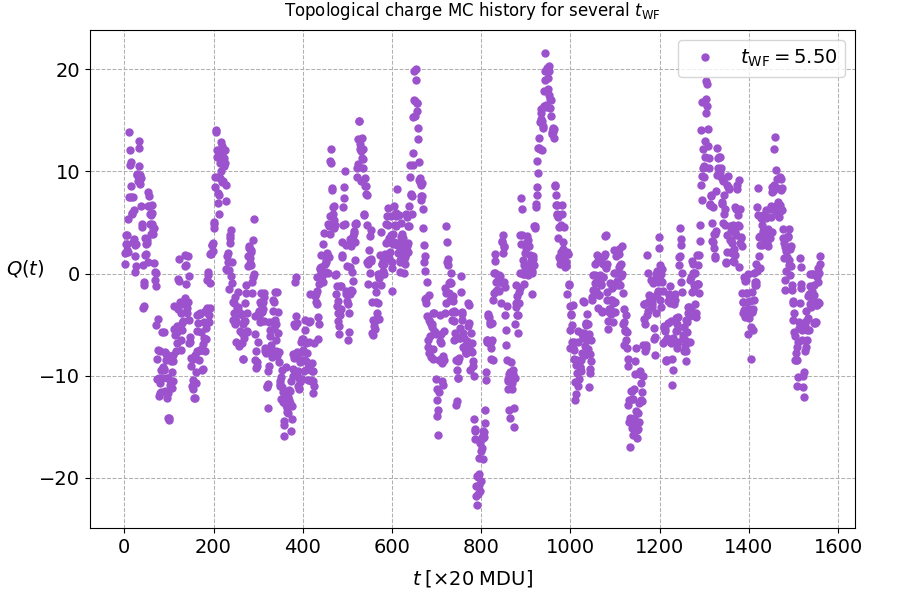

In [9]:
### MC history of Q for several tWF ###

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(f"Topological charge MC history for several $t_{{\mathrm{{WF}}}}$", pad=10)
ax.set_ylabel(r"$Q(t)$", labelpad=10, rotation=0, fontsize=fsize)
ax.set_xlabel(rf'$t \; [\times {int(MC_step * tauMD)} \; \mathrm{{MDU}}]$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.grid(linestyle = '--', linewidth = 0.75)
#plt.xlim([-1, 50.5])
#plt.ylim([1e-2, 1e1])

tWF = np.array([1.50, 3.50, 5.50])
i0  = (tWF / (eps_WF * WF_step)).astype(int)
# ax.plot(np.arange(1, Ncnfg0+1), np.sum(WF_Q[:, i0[0], :], axis=1), label=rf'$t_{{\mathrm{{WF}}}} = {tWF[0]}$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
# ax.plot(np.arange(1, Ncnfg0+1), np.sum(WF_Q[:, i0[1], :], axis=1), label=rf'$t_{{\mathrm{{WF}}}} = {tWF[1]:.2f}$', linestyle='-', marker='o' , markersize=5.0, color='#2bad4e', linewidth=1.0)
ax.plot(np.arange(1, Ncnfg+1), np.sum(WF_Q[skip:, i0[2], :], axis=1)/V, label=rf'$t_{{\mathrm{{WF}}}} = {tWF[2]:.2f}$', linestyle='', marker='o' , markersize=5.0, color='#9b52cc', linewidth=1.0)

#ax.axvspan(0.0, skip, alpha=0.5, color='#808080')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig("tau_int.pdf")

[-20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5
  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5   2.5
   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5  14.5
  15.5  16.5  17.5  18.5  19.5  20.5]


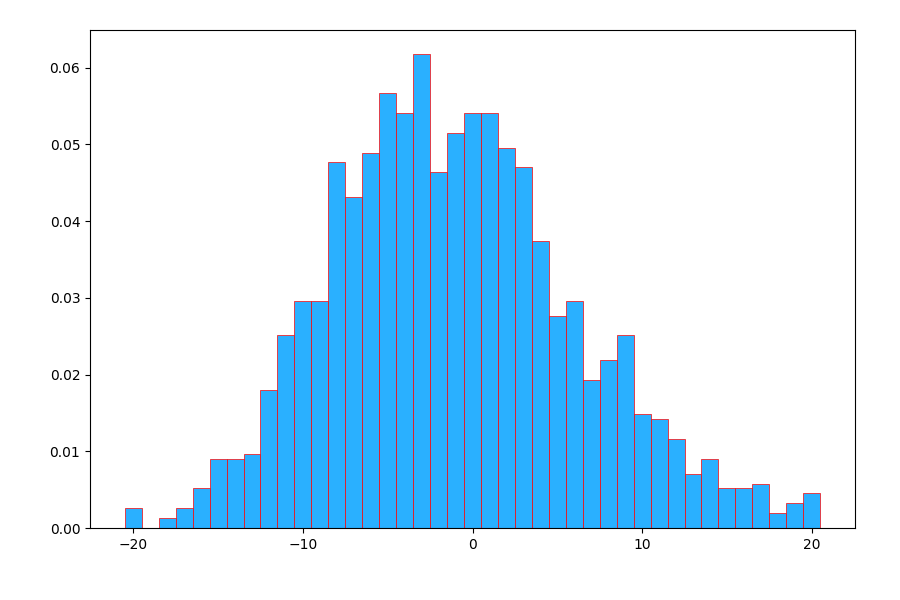

In [10]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))

binwidth = 1.0
data = (np.sum(WF_Q[skip:,i0,:], axis=1)/V).copy()
counts, bins, obj = ax.hist(data, density=True, bins=np.arange(-20.5, 20.5 + binwidth, binwidth), facecolor = '#2ab0ff', edgecolor='red', linewidth=0.5)
print(bins)

# mu, sigma = norm.fit(np.sum(WF_Q[Ntherm0:,i0,:], axis=1)/V)
# best_fit_line = norm.pdf(bins, mu, sigma)
# plt.plot(bins, best_fit_line)
# print(mu, np.sqrt(sigma))

In [11]:
### Compute <Q^2>_t and tau_int ###
obsChi = pyobs.observable(description=f'Topological susceptibility at several WF times')
obsChi.create('Ensemble A', ((np.sum(WF_Q[skip:,:,:], axis=2))**2).flatten(), shape=(Nwf,))
obsChi /= V**2

print(*(f"(t = {t_WF[i]:.2f}) :    Chi = {obsChi[i]}                 tau_int = {obsChi[i].tauint()['Ensemble A'][0][0]:.3f} +- \
{obsChi[i].tauint()['Ensemble A'][1][0]:.3f}\n\n" for i in range(Nwf)), sep='')

(t = 0.00) :    Chi = 41.9(1.6)
                 tau_int = 0.581 +- 0.059

(t = 0.10) :    Chi = 25.7(1.1)
                 tau_int = 0.872 +- 0.108

(t = 0.20) :    Chi = 23.9(2.7)
                 tau_int = 5.285 +- 1.364

(t = 0.30) :    Chi = 28.3(3.8)
                 tau_int = 7.319 +- 2.161

(t = 0.40) :    Chi = 33.2(4.6)
                 tau_int = 7.938 +- 2.412

(t = 0.50) :    Chi = 37.1(5.2)
                 tau_int = 8.101 +- 2.495

(t = 0.60) :    Chi = 40.0(5.7)
                 tau_int = 8.234 +- 2.536

(t = 0.70) :    Chi = 42.2(6.0)
                 tau_int = 8.297 +- 2.555

(t = 0.80) :    Chi = 43.8(6.3)
                 tau_int = 8.323 +- 2.564

(t = 0.90) :    Chi = 45.1(6.5)
                 tau_int = 8.329 +- 2.565

(t = 1.00) :    Chi = 46.2(6.6)
                 tau_int = 8.322 +- 2.563

(t = 1.10) :    Chi = 47.0(6.7)
                 tau_int = 8.310 +- 2.559

(t = 1.20) :    Chi = 47.7(6.8)
                 tau_int = 8.294 +- 2.555

(t = 1.30) :    Chi = 48.

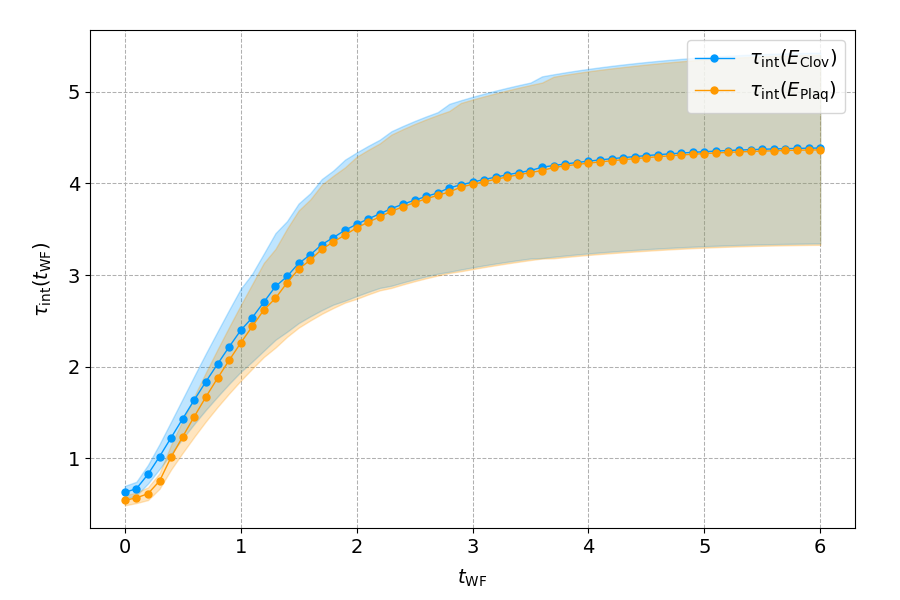

In [12]:
tau_EClov = np.array([np.squeeze(obsEClov[i].tauint()['Ensemble A'], axis=1) for i in range(Nwf)])
tau_EPlaq = np.array([np.squeeze(obsEPlaq[i].tauint()['Ensemble A'], axis=1) for i in range(Nwf)])
tau_Q     = np.array([np.squeeze(obsQ[i].tauint()['Ensemble A'],     axis=1) for i in range(Nwf)])
tau_Q2    = np.array([np.squeeze(obsChi[i].tauint()['Ensemble A'],    axis=1) for i in range(Nwf)])


fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.10)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_ylabel(r"$\tau_\mathrm{int}(t_\mathrm{WF})$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t_\mathrm{WF}$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.xlim([-1, 50.5])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(t_WF, tau_EClov[:,0], label=r'$\tau_\mathrm{int}(E_\mathrm{Clov})$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(t_WF, tau_EClov[:,0] + std * tau_EClov[:,1], tau_EClov[:,0] - std * tau_EClov[:,1], alpha=.25, color='#0099ff')
ax.plot(t_WF, tau_EPlaq[:,0], label=r'$\tau_\mathrm{int}(E_\mathrm{Plaq})$', linestyle='-', marker='o' , markersize=5.0, color='#ff9900', linewidth=1.0)
ax.fill_between(t_WF, tau_EPlaq[:,0] + std * tau_EPlaq[:,1], tau_EPlaq[:,0] - std * tau_EPlaq[:,1], alpha=.25, color='#ff9900')
# ax.plot(t_WF, tau_Q[:,0], label=r'$\tau_\mathrm{int}(Q)$', linestyle='-', marker='o' , markersize=5.0, color='#a151bf', linewidth=1.0)
# ax.fill_between(t_WF, tau_Q[:,0] + std * tau_Q[:,1], tau_Q[:,0] - std * tau_Q[:,1], alpha=.25, color='#a151bf')
# ax.plot(t_WF, tau_Q2[:,0], label=r'$\tau_\mathrm{int}(Q^2)$', linestyle='-', marker='o' , markersize=5.0, color='#d13e27', linewidth=1.0)
# ax.fill_between(t_WF, tau_Q2[:,0] + std * tau_Q2[:,1], tau_Q2[:,0] - std * tau_Q2[:,1], alpha=.25, color='#d13e27')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig("tau_int.pdf")

In [13]:
### Compute t^2<E> for each t_WF ###
obs_t2EClov = (t_WF[1:]**2) * obsEClov[1:]
obs_t2EPlaq = (t_WF[1:]**2) * obsEPlaq[1:]
print("\n")
print(*(f"(t = {t_WF[i+1]:.2f}) :   t^2 <E_Clov> = {obs_t2EClov[i]}               t^2 <E_Plaq> = {obs_t2EPlaq[i]}\n" for i in range(WF_evol // WF_step)), sep='')



(t = 0.10) :   t^2 <E_Clov> = 0.01373092(21)
               t^2 <E_Plaq> = 0.06054021(74)

(t = 0.20) :   t^2 <E_Clov> = 0.03439743(98)
               t^2 <E_Plaq> = 0.1047978(22)

(t = 0.30) :   t^2 <E_Clov> = 0.0493395(23)
               t^2 <E_Plaq> = 0.1151855(38)

(t = 0.40) :   t^2 <E_Clov> = 0.0593605(39)
               t^2 <E_Plaq> = 0.1141976(59)

(t = 0.50) :   t^2 <E_Clov> = 0.0667014(60)
               t^2 <E_Plaq> = 0.1116627(82)

(t = 0.60) :   t^2 <E_Clov> = 0.0726798(86)
               t^2 <E_Plaq> = 0.110218(11)

(t = 0.70) :   t^2 <E_Clov> = 0.077941(11)
               t^2 <E_Plaq> = 0.110160(14)

(t = 0.80) :   t^2 <E_Clov> = 0.082797(15)
               t^2 <E_Plaq> = 0.111224(18)

(t = 0.90) :   t^2 <E_Clov> = 0.087410(19)
               t^2 <E_Plaq> = 0.113095(22)

(t = 1.00) :   t^2 <E_Clov> = 0.091868(23)
               t^2 <E_Plaq> = 0.115530(27)

(t = 1.10) :   t^2 <E_Clov> = 0.096224(27)
               t^2 <E_Plaq> = 0.118361(32)

(t = 1.20) :   t^2 <E_Clov>

In [35]:
### Calculation of t_0 for both E_Clov and E_Plaq ###
eps = 0.01

x, dx = obs_t2EClov.error()
idx_x = np.squeeze(np.where((x < 0.3 + eps) & (x > 0.3 - eps)), axis=0)
print(f"\nE_Clov  :")
print(f"                  E_Clov  =  {x[idx_x]},") 
print(f"                  t_WF    =  {t_WF[idx_x+1]},\n") # recall t_WF starts from 0.0, whose corresponding value is not neither in obs_t2EClov nor in obs_t2EPlaq.
interp_Clov = pyobs.interpolate(t_WF[idx_x+1], obs_t2EClov[idx_x])
obs_t0EClov = interp_Clov.solve(0.3, bracket=[t_WF[(idx_x+1)[0]], t_WF[(idx_x+1)[-1]]])
print(f"                  interpolation  --->  t0/a^2 = {obs_t0EClov}")
t0_EClov, dt0_EClov = np.squeeze(obs_t0EClov.error(), axis=1)

y, dy = obs_t2EPlaq.error()
idx_y = np.squeeze(np.where((y < 0.3 + eps) & (y > 0.3 - eps)), axis=0)
print(f"E_Plaq  :")
print(f"                  E_Plaq  =  {y[idx_y]},") 
print(f"                  t_WF    =  {t_WF[idx_y+1]},\n")
interp_Plaq = pyobs.interpolate(t_WF[idx_y+1], obs_t2EPlaq[idx_y])
obs_t0EPlaq = interp_Plaq.solve(0.3, bracket=[t_WF[(idx_y+1)[0]], t_WF[(idx_y+1)[-1]]])
print(f"                  interpolation  --->  t0/a^2 = {obs_t0EPlaq}")
t0_EPlaq, dt0_EPlaq = np.squeeze(obs_t0EPlaq.error(), axis=1)


E_Clov  :
                  E_Clov  =  [0.29442525 0.29968042 0.30496571],
                  t_WF    =  [5.4 5.5 5.6],

                  interpolation  --->  t0/a^2 = 5.5061(98)

E_Plaq  :
                  E_Plaq  =  [0.29293336 0.29825269 0.3036065  0.30899448],
                  t_WF    =  [5.  5.1 5.2 5.3],

                  interpolation  --->  t0/a^2 = 5.1327(92)



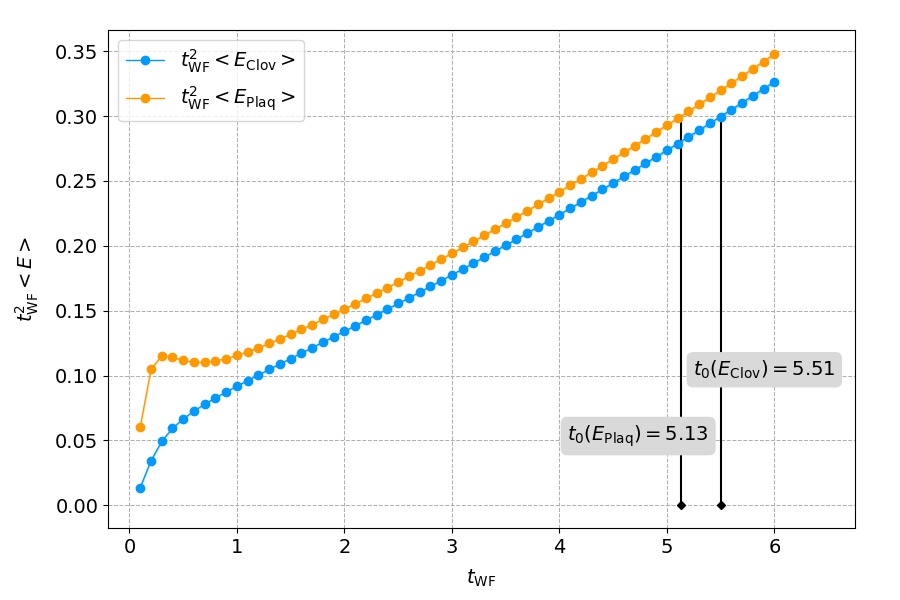

In [15]:
t2EClov = np.array([np.squeeze(obs_t2EClov[i].error(), axis=1) for i in range(WF_evol // WF_step)])
t2EPlaq = np.array([np.squeeze(obs_t2EPlaq[i].error(), axis=1) for i in range(WF_evol // WF_step)])

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.12)
plt.subplots_adjust(right  = 0.95)

fsize = 14
std = 2.0
box = dict(boxstyle="round", color='#d9d9d9')

ax.set_ylabel(r"$t_\mathrm{WF}^2 <E>$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t_\mathrm{WF}$', labelpad=8, fontsize=fsize)

ax.vlines(x = t0_EClov, ymin = 0, ymax = 0.3, colors = 'black', linewidth=1.5)
#ax.scatter(t0_EClov, 0.0, color='black', marker='D', s=12.5)
ax.errorbar(t0_EClov, 0.0, xerr=std*dt0_EClov, color='black', marker='D', markersize=4)
ax.annotate(rf"$t_0(E_\mathrm{{Clov}}) = {t0_EClov:.2f}$", (t0_EClov, 0.10), xytext=(t0_EClov+0.4, 0.10), ha='center', bbox=box, fontsize=fsize)
ax.vlines(x = t0_EPlaq, ymin = 0, ymax = 0.3, colors = 'black', linewidth=1.5)
#ax.scatter(t0_EPlaq, 0.0, color='black', marker='D', s=12.5)
ax.errorbar(t0_EPlaq, 0.0, xerr=std*dt0_EPlaq, color='black', marker='D', markersize=4)
ax.annotate(rf"$t_0(E_\mathrm{{Plaq}}) = {t0_EPlaq:.2f}$", (t0_EPlaq, 0.10), xytext=(t0_EPlaq-0.4, 0.05), ha='center', bbox=box, fontsize=fsize)


plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlim([-0.2, 6.75])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

ax.plot(t_WF[1:], t2EClov[:,0], label=r'$t_\mathrm{WF}^2 <E_\mathrm{Clov}>$', linestyle='-', marker='o' , markersize=6.0, color='#0099ff', linewidth=1.0)
ax.fill_between(t_WF[1:], t2EClov[:,0] + std * t2EClov[:,1], t2EClov[:,0] - std * t2EClov[:,1], alpha=.25, color='#0099ff')
ax.plot(t_WF[1:], t2EPlaq[:,0], label=r'$t_\mathrm{WF}^2 <E_\mathrm{Plaq}>$', linestyle='-', marker='o' , markersize=6.0, color='#ff9900', linewidth=1.0)
ax.fill_between(t_WF[1:], t2EPlaq[:,0] + std * t2EPlaq[:,1], t2EPlaq[:,0] - std * t2EPlaq[:,1], alpha=.25, color='#ff9900')

ax.legend(loc='best', fontsize=fsize)
#plt.savefig('t0E.pdf')

In the python script I measure $\widetilde{q}(t) = \sum_{\mathbf{x}}q(t, \mathbf{x})$ using the function <code>topol_charge(..., field=True)</code> (indeed the function does not include the factor $\times 1/V$). Therefore what we call <b>Topological Charge</b> is
$$
    Q = \frac{1}{V} \sum_t \langle \widetilde{q}(t) \rangle = \frac{1}{V} \sum_{\mathbf{x}, t} \langle q(t, \mathrm{x}) \rangle = \frac{1}{V} \sum_{\mathbf{x}, t} \langle q(0, \mathrm{0}) \rangle \equiv \langle q \rangle \, ,
$$
where we exploited translational invariance in the third step. Thus, we have to average over all MC configurations, sum over $t$ and divide by $V$ to compute the Topological Charge. 

Similarly, the calculation of the <b>Topological Susceptibility</b> $\chi = \frac{Q^2}{V}$ is straightforward
\begin{align*}
    \chi &= \frac{1}{V^2} \sum_{t, t'} \langle \widetilde{q}(t) \widetilde{q}(t') \rangle_c = \frac{1}{V^2} \sum_{t, t'} \sum_{\mathbf{x}, \mathbf{x}'} \langle q(t, \mathrm{x}) q(t', \mathrm{x}') \rangle_c \\
    &= \frac{1}{V^2} \sum_{t, t'} \sum_{\mathbf{x}, \mathbf{z}} \langle q(t, \mathrm{z}) q(0, \mathrm{0}) \rangle_c = \frac{1}{V} \sum_{\mathbf{x}, t} \langle q(t, \mathrm{x}) q(0, \mathrm{0}) \rangle_c \, .
\end{align*}

Equivalently, we can construct an estimator with $T$ more statistics following this procedure. Let's consider the expectation value
$$
    A(t) \equiv \left\langle \frac{1}{T} \sum_{t'} \widetilde{q}(t') \widetilde{q}(t+t') \right\rangle_c = A(t)_\mathrm{conn} + A(t)_\mathrm{disc} \, ;
$$
focusing on its purely connected part we have 
$$
   A(t)_\mathrm{conn} = \frac{1}{T} \sum_{t'} \sum_{\mathbf{x}, \mathbf{y}} \langle q(t', \mathbf{x}) q(t+t', \mathbf{y}) \rangle = \frac{1}{T} \sum_{t'} \sum_{\mathbf{x}, \mathbf{y}} \langle q(t, |\mathbf{x} - \mathbf{y}|) q(0,0) \rangle = \frac{V}{T} \sum_{\mathbf{x}} \langle q(t, \mathbf{x}) q(0,0) \rangle \, ;
$$
therefore 
$$
    \frac{T}{V} A(t)_\mathrm{conn} = \sum_{\mathbf{x}} \langle q(t, \mathbf{x}) q(0,0) \rangle \, ;
$$
similarly, the disconnected term becomes
$$
    A(t)_\mathrm{disc} = \frac{1}{T} \sum_{t'} \sum_{\mathbf{x}, \mathbf{y}} \langle q(t', \mathbf{x}) \rangle \langle q(t+t', \mathbf{y}) \rangle = \frac{1}{T} \sum_{t'} \sum_{\mathbf{x}, \mathbf{y}} \langle q(0,0) \rangle^2 = \frac{V^2}{T^2} \langle q(0,0) \rangle^2 \, .
$$
In other words we obtain
$$
    \chi = \frac{1}{V} \frac{T}{V} \sum_t A(t) = \frac{1}{V} \left\lbrace \sum_{t, \mathbf{x}} \langle q(t, \mathbf{x}) q(0,0) \rangle - \frac{V}{T} \sum_t \langle q(0,0) \rangle^2 \right\rbrace \equiv \frac{1}{V} \sum_t C(t) \, .
$$

In [16]:
### Compute correlator <q(t)q(0)> for a given tWF. ###
t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))
QQ = np.zeros((Ncnfg0, T))
for tp in range(T):
    QQ[:,tp] = np.mean(WF_Q[:,i0,:] * np.roll(WF_Q[:,i0,:], -tp, axis=1), axis=1) 

obsCorr_QQ = pyobs.observable(description=f'Correlator <q(t)q(0)> for tWF = {t0}')
obsCorr_QQ.create('Ensemble A', QQ[skip:,:].flatten(), shape=(T,))
obsCorr_QQ *= T/V
obsCorr_QQ -= pyobs.tile(obsQ[i0] * obsQ[i0], T) * V / T 

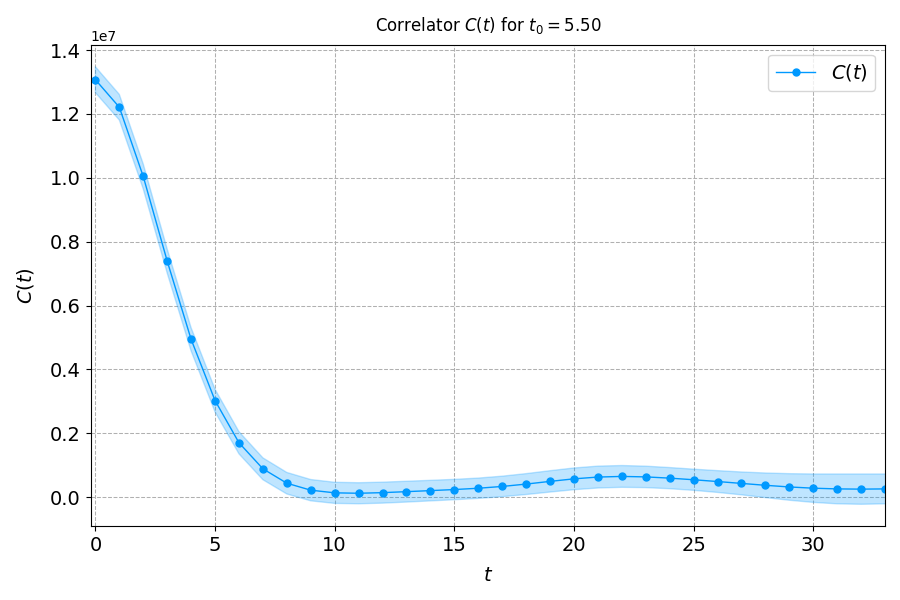

In [17]:
Ct, dCt = obsCorr_QQ.error()

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Correlator $C(t)$ for $t_0 = {t0:.2f}$", pad=10)
ax.set_ylabel(r"$C(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.2, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(T), Ct, label=r'$C(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(T), Ct + std * dCt, Ct - std * dCt, alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [18]:
Tsym = T // 2

obsChi_sum  = 0
Chi_sum     = np.zeros((2, Tsym + 1)) # error and central value

Chi_sum[0, 0]  = obsCorr_QQ[0].error()[0][0]
Chi_sum[1, 0]  = obsCorr_QQ[0].error()[1][0]
for t in range(1, Tsym + 1):
    obsChi_sum  += 2.0 * obsCorr_QQ[t]
    Chi_sum[0, t] = obsChi_sum.error()[0][0]
    Chi_sum[1, t] = obsChi_sum.error()[1][0]
Chi_sum /= V

47.2(8.1)



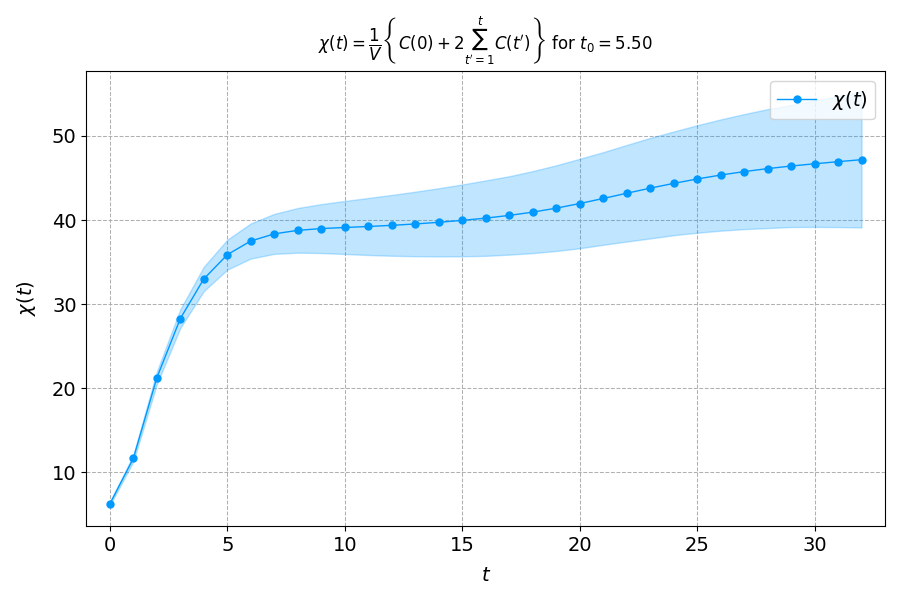

In [19]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"$\chi(t) = \dfrac{{1}}{{V}} \left \{{ C(0) + 2\sum_{{t'=1}}^t C(t') \right \}}$ for $t_0 = {t0:.2f}$", pad=15)
ax.set_ylabel(r"$\chi(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-1, T/2+1])
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(Tsym + 1), Chi_sum[0], label=r'$\chi(t)$', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(Tsym + 1), Chi_sum[0] + std * Chi_sum[1], Chi_sum[0] - std * Chi_sum[1], alpha=.25, color='#0099ff')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

print(obsChi_sum / V)

#plt.savefig("tau_int.pdf")

In [20]:
t_WF = np.array([eps_WF * WF_step * i for i in range(Nwf)])
WF_EPlaq = np.zeros((Ncnfg0, Nwf, T))
WF_EPlaq = ((beta * D * (D-1) / 2)) * (V/T - WF_Plaq)

for t0 in range(Nwf):
    EEClov = np.zeros((Ncnfg0, T))
    EEPlaq = np.zeros((Ncnfg0, T))
    for t in range(T):
        EEClov[:,t] = np.mean(WF_EClov[:,t0,:] * np.roll(WF_EClov[:,t0,:], -t, axis=1), axis=1)
        EEPlaq[:,t] = np.mean(WF_EPlaq[:,t0,:] * np.roll(WF_EPlaq[:,t0,:], -t, axis=1), axis=1)

    ### <EE>_Clov ###
    obsCorr_EEClov = pyobs.observable(description=f'<E(t)E(0)>_Clov for tWF = {t_WF[t0]}')
    obsCorr_EEClov.create('Ensemble A', EEClov[skip:,:].flatten(), shape=(T,))
    obsCorr_EEClov *= T/V 
    obsCorr_EEClov -= pyobs.tile(obsEClov[t0] * obsEClov[t0], T) * V / T
    
    ### <EE>_Plaq ###
    obsCorr_EEPlaq = pyobs.observable(description=f'<E(t)E(0)>_Plaq for tWF = {t_WF[t0]}')
    obsCorr_EEPlaq.create('Ensemble A', EEPlaq[skip:,:].flatten(), shape=(T,))
    obsCorr_EEPlaq *= T/V 
    obsCorr_EEPlaq -= pyobs.tile(obsEPlaq[t0] * obsEPlaq[t0], T) * V / T

    ### save observables ###
    #pyobs.save(f'PyObs/Corr_EClov_tWF{t_WF[t0]:.2f}.pyobs', obsCorr_EEClov)
    #pyobs.save(f'PyObs/Corr_EPlaq_tWF{t_WF[t0]:.2f}.pyobs', obsCorr_EEPlaq)

[Bison] : Written 0.765433 MB at 32.1841 MB/s
[Bison] : Written 0.765429 MB at 31.1376 MB/s
[Bison] : Written 0.765433 MB at 37.5391 MB/s
[Bison] : Written 0.765429 MB at 32.909 MB/s
[Bison] : Written 0.765433 MB at 38.4215 MB/s
[Bison] : Written 0.765429 MB at 37.078 MB/s
[Bison] : Written 0.765449 MB at 32.0389 MB/s
[Bison] : Written 0.765444 MB at 35.8619 MB/s
[Bison] : Written 0.765433 MB at 32.2455 MB/s
[Bison] : Written 0.765429 MB at 35.4753 MB/s
[Bison] : Written 0.765433 MB at 45.0673 MB/s
[Bison] : Written 0.765429 MB at 39.0322 MB/s
[Bison] : Written 0.765448 MB at 31.0372 MB/s
[Bison] : Written 0.765443 MB at 36.151 MB/s
[Bison] : Written 0.765448 MB at 36.7863 MB/s
[Bison] : Written 0.765443 MB at 35.9901 MB/s
[Bison] : Written 0.765433 MB at 32.8436 MB/s
[Bison] : Written 0.765429 MB at 36.1911 MB/s
[Bison] : Written 0.765433 MB at 39.7221 MB/s
[Bison] : Written 0.765429 MB at 46.7231 MB/s
[Bison] : Written 0.765433 MB at 35.912 MB/s
[Bison] : Written 0.765429 MB at 35.14

## Autocorrelation functions calculations

In [21]:
### Compute autocorrelation functions for each <E_Clov>_t and <E_Plaq>_t ###
gammaEClov = []
gammaEPlaq = []
gammaQ     = []
gammaQ2    = []
if (obsEClov.shape[0] == Nwf) and (obsEPlaq.shape[0] == Nwf) \
    and (obsQ.shape[0] == Nwf) and (obsChi.shape[0] == Nwf):
    for i in range(Nwf): 
        norm, gamma = obsEClov[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaEClov.append(gamma)
        norm, gamma = obsEPlaq[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaEPlaq.append(gamma)
        norm, gamma = obsQ[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaQ.append(gamma)
        norm, gamma = obsChi[i].delta['Ensemble A:0'].gamma(Ncnfg, 0)
        gamma = gamma / norm
        gammaQ2.append(gamma)
else:
    print(f"Check observables shapes !")

norm, gamma_t0EClov = obs_t0EClov.delta['Ensemble A:0'].gamma(Ncnfg, 0)
gamma_t0EClov = gamma_t0EClov / norm 

norm, gamma_t0EPlaq = obs_t0EPlaq.delta['Ensemble A:0'].gamma(Ncnfg, 0)
gamma_t0EPlaq = gamma_t0EPlaq / norm 

gammaEClov = np.array(gammaEClov)
gammaEPlaq = np.array(gammaEPlaq)
gammaQ     = np.array(gammaQ)
gammaQ2    = np.array(gammaQ2)

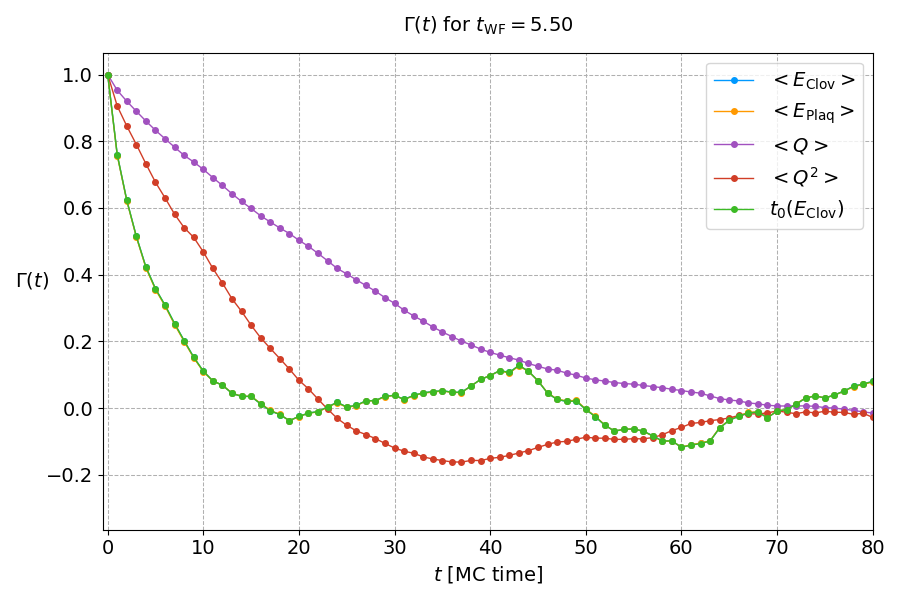

In [22]:
fig, ax = plt.subplots(figsize=(9, 6))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)
fsize = 14

tmax = Ncnfg // 4
t = 5.50
i = int(t / (eps_WF * WF_step)) 

plt.title(rf'$\Gamma(t)$ for $t_\mathrm{{WF}}={t:.2f}$', pad=15, fontsize=fsize)

ax.plot(np.arange(tmax), gammaEClov[i,:tmax]/gammaEClov[i,0], color='#0099ff', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<E_\mathrm{{Clov}}>$')
ax.plot(np.arange(tmax), gammaEPlaq[i,:tmax]/gammaEPlaq[i,0], color='#ff9900', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<E_\mathrm{{Plaq}}>$')
ax.plot(np.arange(tmax), gammaQ[i,:tmax]/gammaQ[i,0], color='#a151bf', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<Q>$')
ax.plot(np.arange(tmax), gammaQ2[i,:tmax]/gammaQ2[i,0], color='#d13e27', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$<Q^2>$')
ax.plot(np.arange(tmax), gamma_t0EClov[:tmax]/gamma_t0EClov[0], color='#3cba25', \
        marker='o',     linestyle='-',       linewidth='1.0', \
        markersize=4.0,   label=rf'$t_0(E_\mathrm{{Clov}})$')
ax.set_xlabel(r'$t$ [MC time]', fontsize=fsize)
ax.set_ylabel(r'$\Gamma(t)$', rotation=0, labelpad=10, fontsize=fsize)
ax.legend(loc='best', fontsize=fsize)


plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.xlim([-0.5, 80])
#plt.ylim([1e-2, 1e1])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log', base=10)
ax.grid(linestyle = '--', linewidth = 0.75)

fig.tight_layout()

## Bounding Method application

In [23]:
### Bounding Method ###
t0 = 5.50
i0 = int(t0 / (eps_WF * WF_step))
tau0 = obsQ[i0].tauint()['Ensemble A'][0][0]
print(f"\n tau_slow for bounding = {tau0:.2f}, which is {int(tau0 * tauMD * MC_step)} MDU\n")

Tmax = 40
for t in range(Tmax):
   # print(f" t0     :    tau_eff(W={t}) = {1.0 / np.log(gamma_t0EClov[t] / gamma_t0EClov[t+1]):.3f},")
   print(f" Q      :    tau_eff(W={t}) = {1.0 / np.log(gammaQ[i0, t] / gammaQ[i0, t+1]):.3f},")
   # print(f" Q^2   :    tau_eff(W={t}) = {1.0 / np.log(gammaQ2[i0, t] / gammaQ2[i0, t+1]):.3f},")
print("\n")


 tau_slow for bounding = 23.05, which is 461 MDU

 Q      :    tau_eff(W=0) = 20.592,
 Q      :    tau_eff(W=1) = 28.535,
 Q      :    tau_eff(W=2) = 30.155,
 Q      :    tau_eff(W=3) = 29.828,
 Q      :    tau_eff(W=4) = 30.565,
 Q      :    tau_eff(W=5) = 32.116,
 Q      :    tau_eff(W=6) = 31.661,
 Q      :    tau_eff(W=7) = 31.270,
 Q      :    tau_eff(W=8) = 37.857,
 Q      :    tau_eff(W=9) = 33.071,
 Q      :    tau_eff(W=10) = 28.433,
 Q      :    tau_eff(W=11) = 28.780,
 Q      :    tau_eff(W=12) = 26.392,
 Q      :    tau_eff(W=13) = 27.332,
 Q      :    tau_eff(W=14) = 28.936,
 Q      :    tau_eff(W=15) = 26.702,
 Q      :    tau_eff(W=16) = 30.887,
 Q      :    tau_eff(W=17) = 30.605,
 Q      :    tau_eff(W=18) = 31.961,
 Q      :    tau_eff(W=19) = 25.387,
 Q      :    tau_eff(W=20) = 27.045,
 Q      :    tau_eff(W=21) = 22.437,
 Q      :    tau_eff(W=22) = 20.406,
 Q      :    tau_eff(W=23) = 18.827,
 Q      :    tau_eff(W=24) = 25.006,
 Q      :    tau_eff(W=25) = 22.31

In [24]:
def Cbar_W(gamma, W):
    """ returns Cbar(W) = gamma(0) + 2*sum_{i=1}^W gamma(i) """
    return gamma[0] + 2.0 * np.sum(gamma[1:W+1])

def sys_err(gammaW, W, tau_slow, tau_effW):
    """ returns the systematic effect coming from the truncation 
    of the sum of the autocorrelation function up to a window W. 
    This quantity is computed in a data-driven way, i.e. the error is 
    is given by a difference between the bounds (see eqs 4.2.1 master thesis),
    namely
        2*sum_{i=W+1}^infty{ gamma_upp(t|W, tau0) - gamma_low(t|W, tau_eff^W) }
    """
    cutoff_low = int(np.ceil(3.0 * tau_effW * np.log(10)))
    cutoff_upp = int(np.ceil(3.0 * tau_slow * np.log(10)))
    if cutoff_upp < W:
        cutoff_upp *= 2
    if cutoff_low < W:
        cutoff_low *= 2
    sum_upp = np.sum(np.exp(- (np.arange(cutoff_upp - W) + 1) / tau_slow))
    sum_low = np.sum(np.exp(- (np.arange(cutoff_low - W) + 1) / tau_effW))
    return 2.0 * gammaW * (sum_upp - sum_low)

In [29]:
########################
### Bounding routine ###
########################
# gamma is a numpy array of size Nconf containing the values of the
# autocorrelation function for a given observable. 
def bounding(gamma, tau_slow, cnfg, M=2.0):
    W = 0
    # Assume first W is ok by default:
    arg_o     = gamma[W] / gamma[W + 1]
    tau_eff_o = 1.0 / np.log(arg_o)
    LHS_o     = np.sqrt((4.0 * W + 2.0) / cnfg)
    cbar_o    = Cbar_W(gamma, W)      # this is only gamma[0] for W = 0
    RHS_o     = M * sys_err(gamma[W], W, tau_slow, tau_eff_o) / cbar_o
    print(f"\n slowest mode = {tau_slow}\n")
    print(f" W = {W},  tau_eff^W = {tau_eff_o},  LHS - RHS = {LHS_o - RHS_o},  err = {np.sqrt(cbar_o/cnfg)}")
    W = 1
    while W < cnfg:
        arg_n = gamma[W] / gamma[W + 1]
        if (arg_n <= 1.0) or (1.0/np.log(arg_n) >= tau_slow):
            arg_n = arg_o # uses the last tau_eff that is ok
            
        tau_eff_n = 1.0 / np.log(arg_n)
        LHS_n     = np.sqrt((4.0 * W + 2.0) / cnfg)
        cbar_n    = Cbar_W(gamma, W)
        RHS_n     = M * sys_err(gamma[W], W, tau_slow, tau_eff_n) / cbar_n
        
        print(f" W = {W},  tau_eff^W = {tau_eff_n},  LHS - RHS = {LHS_n - RHS_n},  err = {np.sqrt(cbar_n/cnfg)}")

        if ((LHS_o - RHS_o < 0.0) and (LHS_n - RHS_n >= 0.0)): # change of sign with current W --> return new.
            return W
        elif ((LHS_o - RHS_o < 0.0) and (LHS_n - RHS_n < 0.0)): # not yet change of sign. 
            arg_o, LHS_o, RHS_o, cbar_o  = arg_n, LHS_n, RHS_n, cbar_n
            W += 1
        else: # both differences are positive
            print(f"Both differences at {W} and {W+1} are positive.")
            if (LHS_o - RHS_o) > (LHS_n - RHS_n):
                arg_o, LHS_o, RHS_o, cbar_o  = arg_n, LHS_n, RHS_n, cbar_n
                W += 1
            else:
                return W-1
#gamma = gamma_t0EClov              
#gamma = gammaQ[i0, :]
gamma = gammaQ2[i0, :]

W_bnd = bounding(gamma, 4*tau0, Ncnfg)
    
print(f"\n W_bnd     = {W_bnd}")
W = W_bnd
print(f" err(W={W}) = {np.sqrt(Cbar_W(gamma, W)/Ncnfg)}")



 slowest mode = 92.20060428780252

 W = 0,  tau_eff^W = 10.079793709053543,  LHS - RHS = -328.08854792847,  err = 1.915523371368831
 W = 1,  tau_eff^W = 14.543559075285655,  LHS - RHS = -99.89509205555278,  err = 3.21163527326298
 W = 2,  tau_eff^W = 14.819863913790256,  LHS - RHS = -57.98148749196843,  err = 4.064283292652053
 W = 3,  tau_eff^W = 13.119347091837035,  LHS - RHS = -40.95852771982387,  err = 4.724128870894915
 W = 4,  tau_eff^W = 12.757426272937677,  LHS - RHS = -30.691269958235367,  err = 5.262204481546882
 W = 5,  tau_eff^W = 13.948559927614015,  LHS - RHS = -23.664182336385338,  err = 5.714812802662791
 W = 6,  tau_eff^W = 12.378067251292627,  LHS - RHS = -19.65177582163016,  err = 6.106034418744089
 W = 7,  tau_eff^W = 13.888522106480423,  LHS - RHS = -15.924317073811718,  err = 6.44587546128585
 W = 8,  tau_eff^W = 18.136659417403056,  LHS - RHS = -12.755947897358345,  err = 6.7467492826258315
 W = 9,  tau_eff^W = 11.309718138941372,  LHS - RHS = -12.16404146328505

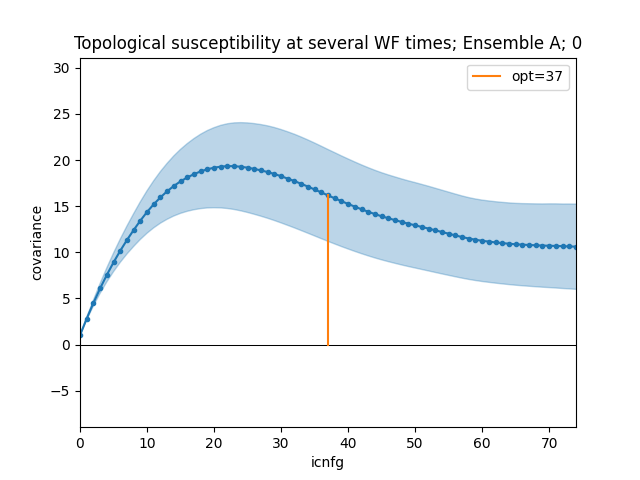

[54.51880846] [7.70160743]


In [31]:
#e, de = obs_t0EClov.error(plot=True)
#e, de = obsQ[i0].error(plot=True)
e, de = obsChi[i0].error(plot=True)
print(e, de)

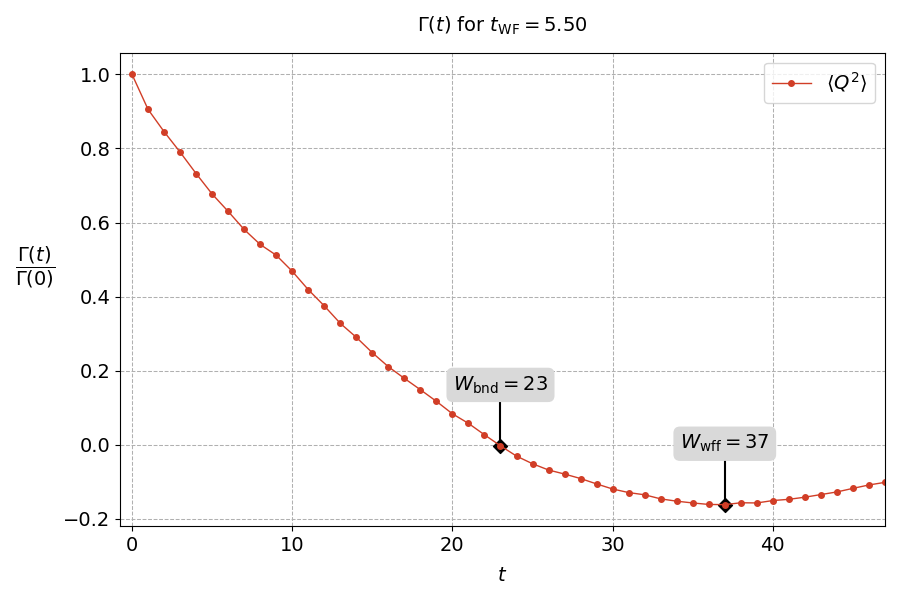

In [34]:
### Bounding plots of W_bnd for the Gammas above ###

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.12)
plt.subplots_adjust(right  = 0.95)

### W results: ###
W_bnd_t0, W_wff_t0 = 17, 22
W_bnd_Q,  W_wff_Q  = 54, 81
W_bnd_Q2, W_wff_Q2 = 23, 37 

fsize = 14
box = dict(boxstyle="round", color='#d9d9d9')

tmax = Ncnfg // 4
t = 5.50
i = int(t / (eps_WF * WF_step)) 

plt.title(rf'$\Gamma(t)$ for $t_\mathrm{{WF}}={t:.2f}$', pad=15, fontsize=fsize)

ax.set_ylabel(r"$\dfrac{\Gamma(t)}{\Gamma(0)}$", labelpad=20, rotation=0, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)



### t0(E_clov) ###
# ax.plot(np.arange(tmax), gamma_t0EClov[:tmax]/gamma_t0EClov[0], color='#3cba25', \
#         marker='o',     linestyle='-',       linewidth='1.5', \
#         markersize=5.0,   label=rf'$t_0(E_\mathrm{{Clov}})$')
# ax.scatter(W_bnd_t0, gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0], color='black', marker='D', s=50)
# ax.vlines(x = W_bnd_t0, ymin = gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0], ymax = gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{bnd}} = {W_bnd_t0}$", (W_bnd_t0, 0.40), xytext=(W_bnd_t0-1.3, gamma_t0EClov[W_bnd_t0]/gamma_t0EClov[0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# ax.scatter(W_wff_t0, gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0], color='black', marker='D', s=50)
# ax.vlines(x = W_wff_t0, ymin = gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0], ymax = gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{wff}} = {W_wff_t0}$", (W_wff_t0, 0.40), xytext=(W_wff_t0+1.3, gamma_t0EClov[W_wff_t0]/gamma_t0EClov[0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# plt.xlim([-0.2, W_wff_t0+4])



### Q ###
# ax.plot(np.arange(tmax), gammaQ[i,:tmax]/gammaQ[i,0], color='#a151bf', \
#         marker='o',     linestyle='-',       linewidth='1.0', \
#         markersize=4.0,   label=rf'$<Q>$')
# ax.scatter(W_bnd_Q, gammaQ[i,W_bnd_Q]/gammaQ[i,0], color='black', marker='D', s=50)
# ax.vlines(x = W_bnd_Q, ymin = gammaQ[i,W_bnd_Q]/gammaQ[i,0], ymax = gammaQ[i,W_bnd_Q]/gammaQ[i,0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{bnd}} = {W_bnd_Q}$", (W_bnd_Q, 0.40), xytext=(W_bnd_Q, gammaQ[i,W_bnd_Q]/gammaQ[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# ax.scatter(W_wff_Q, gammaQ[i,W_wff_Q]/gammaQ[i,0], color='black', marker='D', s=50)
# ax.vlines(x = W_wff_Q, ymin = gammaQ[i,W_wff_Q]/gammaQ[i,0], ymax = gammaQ[i,W_wff_Q]/gammaQ[i,0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{wff}} = {W_wff_Q}$", (W_wff_Q, 0.40), xytext=(W_wff_Q, gammaQ[i,W_wff_Q]/gammaQ[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# plt.xlim([-0.75, W_wff_Q + 10])
# plt.ylim([-0.1, 1.025])



### Q^2 ###
# ax.plot(np.arange(tmax), gammaQ2[i,:tmax]/gammaQ2[i,0], color='#d13e27', \
#         marker='o',     linestyle='-',       linewidth='1.0', \
#         markersize=4.0,   label=rf'$\langle Q^2 \rangle$')
# ax.scatter(W_bnd_Q2, gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0], color='black', marker='D', s=50)
# ax.vlines(x = W_bnd_Q2, ymin = gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0], ymax = gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{bnd}} = {W_bnd_Q2}$", (W_bnd_Q2, 0.40), xytext=(W_bnd_Q2, gammaQ2[i,W_bnd_Q2]/gammaQ2[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# ax.scatter(W_wff_Q2, gammaQ2[i,W_wff_Q2]/gammaQ2[i,0], color='black', marker='D', s=50)
# ax.vlines(x = W_wff_Q2, ymin = gammaQ2[i,W_wff_Q2]/gammaQ2[i,0], ymax = gammaQ2[i,W_wff_Q2]/gammaQ2[i,0] + 0.15, colors = 'black', linewidth=1.5)
# ax.annotate(rf"$W_\mathrm{{wff}} = {W_wff_Q2}$", (W_wff_Q2, 0.40), xytext=(W_wff_Q2, gammaQ2[i,W_wff_Q2]/gammaQ2[i,0] + 0.15), ha='center', bbox=box, fontsize=fsize)
# plt.xlim([-0.75, W_wff_Q2+10])
# # plt.ylim([-0.1, 1.025])




plt.yticks(fontsize=fsize)
plt.xticks(fontsize=fsize)
#plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)

ax.legend(loc='best', fontsize=fsize)
fig.tight_layout()
#plt.savefig('t0E.pdf')